In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import regex as re
import gensim
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [4]:
dataset = pd.read_excel('metoo_tweets_dec2017.xlsx')

In [5]:
dataset=dataset[dataset['text'].notna()]
dataset.head()

,column_a,text,favorited,favoritecount,replytosn,created,truncated,replytosid,id,replytouid,statussource,screenname,retweetcount,isretweet,retweeted,longitude,latitude,location
0,1.0,American Harem.. #MeToo https://t.co/HjExLJdGuF,0.0,0.0,NaN,2017-11-29T23:59:00,0.0,NaN,9.360000e+17,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",ahmediaTV,0.0,0.0,0.0,NaN,NaN,NaN
1,2.0,@johnconyersjr @alfranken why have you guys ...,0.0,0.0,johnconyersjr,2017-11-29T23:59:00,0.0,NaN,9.360000e+17,266149840.0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",JesusPrepper74,0.0,0.0,0.0,NaN,NaN,NaN
2,3.0,Watched Megan Kelly ask Joe Keery this A.M. if...,0.0,0.0,NaN,2017-11-29T23:59:00,1.0,NaN,9.360000e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",DemerisePotvin,0.0,0.0,0.0,NaN,NaN,NaN
3,4.0,Women have been talking about this crap the en...,0.0,0.0,NaN,2017-11-29T23:59:00,0.0,NaN,9.360000e+17,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",TheDawnStott,0.0,0.0,0.0,NaN,NaN,NaN
4,5.0,.@BetteMidler please speak to this sexual assa...,0.0,15.0,NaN,2017-11-29T23:59:00,0.0,NaN,9.360000e+17,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",scottygirl2014,11.0,0.0,0.0,NaN,NaN,NaN


In [6]:
dataset1=dataset[0:10000]
dataset['text'] = dataset.text.values.astype('str').tolist()
print(dataset['text'])
# remove characters
dataset['text'] = [re.sub('\s+', ' ', sent) for sent in dataset['text']]
dataset['text'] = [re.sub("\'", "", sent) for sent in dataset['text']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

0           American Harem.. #MeToo https://t.co/HjExLJdGuF
1         @johnconyersjr  @alfranken  why have you guys ...
2         Watched Megan Kelly ask Joe Keery this A.M. if...
3         Women have been talking about this crap the en...
4         .@BetteMidler please speak to this sexual assa...
                                ...                        
398662    RT @Suffragentleman: You can only choose one.....
398663    #MeToo, say victims of sexual harassment in Ja...
398664    Susan Collins tries to #MeToo her way out of h...
398665    RT @OneMillionVjj: Punish those who choose not...
398666    Chief Justice John Roberts orders misconduct r...
Name: text, Length: 393132, dtype: object


In [7]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [27]:
tokens_reviews = list(sent_to_words(dataset['text']))

In [28]:
tokens_reviews = make_n_grams(tokens_reviews)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [10]:
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 2.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [29]:
import spacy
from gensim.utils import simple_preprocess
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include','https','let','½i','½_i']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
text_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])
print(text_lemmatized)

# remove stop words after lemmatization
text_lemmatized = remove_stopwords(text_lemmatized)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
pip install git+https://github.com/rwalk/gsdmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-tevy6wj7
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-tevy6wj7
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4601 sha256=b40267ec15c5633d3910b90c39a768ae4c45f83fd18d43b973072f3cd1719ff3
  Stored in directory: /tmp/pip-ephem-wheel-cache-3lycfut4/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm


In [31]:
from gsdmm import MovieGroupProcess
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.3, n_iters=30)

vocab = set(x for text in text_lemmatized for x in text)
n_terms = len(vocab)
model = mgp.fit(text_lemmatized, n_terms)

In stage 0: transferred 344168 clusters with 10 clusters populated
In stage 1: transferred 259222 clusters with 10 clusters populated
In stage 2: transferred 164581 clusters with 10 clusters populated
In stage 3: transferred 124883 clusters with 10 clusters populated
In stage 4: transferred 107569 clusters with 10 clusters populated
In stage 5: transferred 97062 clusters with 10 clusters populated
In stage 6: transferred 89326 clusters with 10 clusters populated
In stage 7: transferred 84249 clusters with 10 clusters populated
In stage 8: transferred 80697 clusters with 10 clusters populated
In stage 9: transferred 77974 clusters with 10 clusters populated
In stage 10: transferred 76044 clusters with 10 clusters populated
In stage 11: transferred 74654 clusters with 10 clusters populated
In stage 12: transferred 73291 clusters with 10 clusters populated
In stage 13: transferred 72225 clusters with 10 clusters populated
In stage 14: transferred 71264 clusters with 10 clusters populated


In [32]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [33]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [ 18691  35880  20471  25425  60273  23339  31949  19897 131486  25721]

Most important clusters (by number of docs inside): [8 4 1 6 9 3 5 2 7 0]

Cluster 8 : [('metoo', 51554), ('woman', 20557), ('movement', 11693), ('man', 11109), ('amp', 5979), ('know', 5440), ('trump', 5425), ('realdonaldtrump', 5089), ('story', 4910), ('people', 4813)]

Cluster 4 : [('metoo', 25024), ('harassment', 9933), ('woman', 9743), ('movement', 5621), ('abuse', 4089), ('story', 3597), ('assault', 3319), ('man', 2965), ('amp', 2501), ('work', 2230)]

Cluster 1 : [('metoo', 24388), ('shout', 15942), ('story', 12942), ('amp', 11030), ('woman', 9641), ('outa', 5466), ('refuse', 4824), ('society', 4736), ('confront', 4731), ('movement', 3451)]

Cluster 6 : [('metoo', 13861), ('year', 12131), ('person', 7484), ('movement', 7437), ('woman', 3266), ('silence_breaker', 2575), ('thank', 2229), ('start', 2190), ('taranaburke', 1741), ('spend', 1426)]

Cluster 9 : [('movement', 17719), 

In [34]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
               'type 7',
               'type 8',
               'type 9',
               'type 10'
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [35]:
def create_topics_dataframe(data_text=dataset1.text,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=text_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(text_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [36]:
result = create_topics_dataframe(data_text=dataset1.text, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=text_lemmatized)
result.head(5)

,Text,Topic,Lemma-text
0,American Harem.. #MeToo https://t.co/HjExLJdGuF,type 4,[hjexljdguf]
1,@johnconyersjr @alfranken why have you guys no...,type 1,"[alfranken, guy, resign, hypocrisy, metoo]"
2,Watched Megan Kelly ask Joe Keery this A.M. if...,type 1,"[watch, megan_kelly, keery, rub, finger, hair,..."
3,Women have been talking about this crap the en...,type 1,"[woman, talk, crap, finally, listen, jlk]"
4,.@BetteMidler please speak to this sexual assa...,type 1,"[bettemidler, speak, assault, geraldorivera, i..."


In [37]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [38]:
from wordcloud import WordCloud 
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

In [39]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [40]:
result = result.drop('Lemma-text', axis=1)

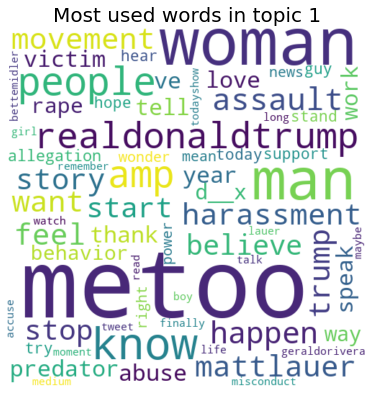

In [45]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

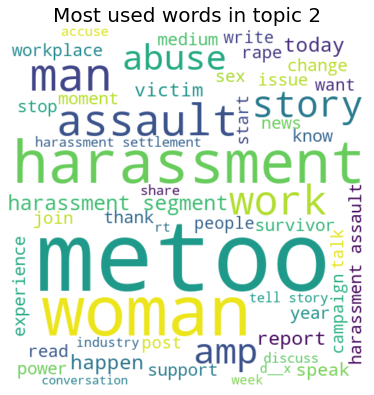

In [46]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

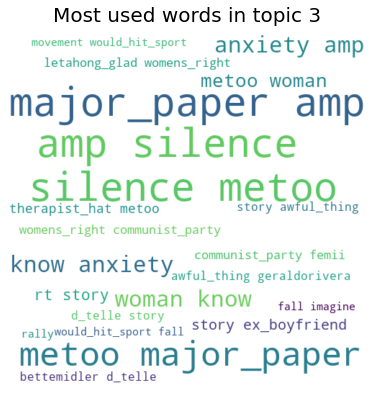

In [47]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

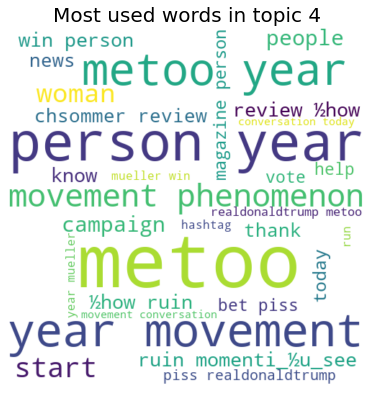

In [48]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

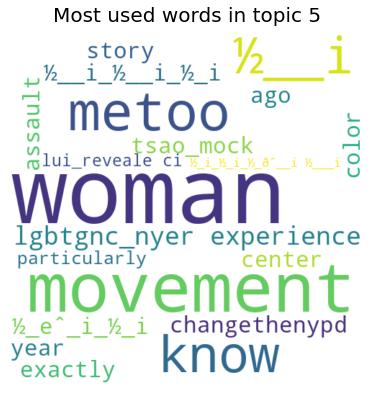

In [49]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")